Sentiment timestamps were converted from UNIX seconds and aggregated to daily level before merging to avoid many-to-many join expansion.


In [1]:
import pandas as pd

# LOAD CORRECT FILES
sentiment = pd.read_csv("fear_greed_index.csv")     # sentiment data
trades = pd.read_csv("historical_data.csv")         # trade data

# CLEAN COLUMNS
sentiment.columns = sentiment.columns.str.strip().str.lower().str.replace(" ", "_")
trades.columns = trades.columns.str.strip().str.lower().str.replace(" ", "_")

print("SENTIMENT:", list(sentiment.columns))
print("TRADES:", list(trades.columns))



SENTIMENT: ['timestamp', 'value', 'classification', 'date']
TRADES: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']


In [2]:
# TRADES → use timestamp_ist (real time)
trades['timestamp_ist'] = pd.to_datetime(trades['timestamp_ist'], format='%d-%m-%Y %H:%M', errors='coerce')
trades['date'] = trades['timestamp_ist'].dt.date

# SENTIMENT
sentiment['timestamp'] = pd.to_datetime(sentiment['timestamp'], errors='coerce')
sentiment['date'] = sentiment['timestamp'].dt.date


In [3]:
print(trades[['timestamp_ist','date']].head())
print(sentiment[['timestamp','date']].head())


        timestamp_ist        date
0 2024-12-02 22:50:00  2024-12-02
1 2024-12-02 22:50:00  2024-12-02
2 2024-12-02 22:50:00  2024-12-02
3 2024-12-02 22:50:00  2024-12-02
4 2024-12-02 22:50:00  2024-12-02
                      timestamp        date
0 1970-01-01 00:00:01.517463000  1970-01-01
1 1970-01-01 00:00:01.517549400  1970-01-01
2 1970-01-01 00:00:01.517635800  1970-01-01
3 1970-01-01 00:00:01.517722200  1970-01-01
4 1970-01-01 00:00:01.517808600  1970-01-01


In [4]:
daily_sentiment = sentiment.groupby('date', as_index=False)['value'].mean()
daily_sentiment.rename(columns={'value':'daily_sentiment'}, inplace=True)


daily_sentiment.head()


,date,daily_sentiment
0,1970-01-01,46.981089


In [5]:
merged = pd.merge(trades, daily_sentiment, on='date', how='left')
print("Merged shape:", merged.shape)
merged.head()


Merged shape: (211224, 18)


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp,date,daily_sentiment
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,NaN
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,NaN
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,NaN
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,NaN
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,NaN


In [6]:
daily_pnl = merged.groupby(['date','account'], as_index=False)['closed_pnl'].sum()
daily_pnl.head()


,date,account,closed_pnl
0,2023-05-01,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.000000
1,2023-12-05,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,0.000000
2,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,-205.434737
3,2023-12-15,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,-24.632034
4,2023-12-16,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,0.000000


In [7]:
merged['win'] = merged['closed_pnl'] > 0

win_rate = merged.groupby('account')['win'].mean().reset_index()
win_rate['win_rate_%'] = win_rate['win'] * 100
win_rate.drop(columns='win', inplace=True)

win_rate.head()


,account,win_rate_%
0,0x083384f897ee0f19899168e3b1bec365f52a9012,35.961236
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,44.271978
2,0x271b280974205ca63b716753467d5a371de622ab,30.191651
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,43.858463
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,51.991355


In [8]:
avg_trade_size = merged.groupby('account', as_index=False)['size_usd'].mean()
avg_trade_size.rename(columns={'size_usd':'avg_trade_size_usd'}, inplace=True)

avg_trade_size.head()


,account,avg_trade_size_usd
0,0x083384f897ee0f19899168e3b1bec365f52a9012,16159.576734
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1653.226327
2,0x271b280974205ca63b716753467d5a371de622ab,8893.000898
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,507.626933
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,3138.894782


In [9]:
trades_per_day = merged.groupby('date').size().reset_index(name='trades_count')
trades_per_day.head()


,date,trades_count
0,2023-05-01,3
1,2023-12-05,9
2,2023-12-14,11
3,2023-12-15,2
4,2023-12-16,3


In [10]:
long_short_ratio = merged['side'].value_counts(normalize=True) * 100
print(long_short_ratio)


side
SELL    51.380525
BUY     48.619475
Name: proportion, dtype: float64


In [11]:
merged['leverage'] = merged['size_usd'] / merged['size_usd'].median()
merged['leverage'].describe()


count    211224.000000
mean          9.445605
std          61.260271
min           0.000000
25%           0.324582
50%           1.000000
75%           3.448584
max        6568.065590
Name: leverage, dtype: float64

In [12]:
# convert string → number → datetime
sentiment['timestamp'] = pd.to_numeric(sentiment['timestamp'], errors='coerce')
sentiment['timestamp'] = pd.to_datetime(sentiment['timestamp'], unit='s')

sentiment['date'] = sentiment['timestamp'].dt.date




In [13]:
print("Trades date sample:", trades['date'].head())
print("Sentiment date sample:", sentiment['date'].head())

print("Common dates:",
      len(set(trades['date']).intersection(set(sentiment['date']))))


Trades date sample: 0    2024-12-02
1    2024-12-02
2    2024-12-02
3    2024-12-02
4    2024-12-02
Name: date, dtype: object
Sentiment date sample: 0    2018-02-01
1    2018-02-02
2    2018-02-03
3    2018-02-04
4    2018-02-05
Name: date, dtype: object
Common dates: 479


In [14]:
# average sentiment score per day
daily_sentiment = sentiment.groupby('date', as_index=False)['value'].mean()

# daily sentiment category (Fear/Greed label)
daily_class = sentiment.groupby('date')['classification'] \
                       .agg(lambda x: x.mode()[0]) \
                       .reset_index()


In [15]:
merged = pd.merge(trades, daily_sentiment, on='date', how='left')
merged = pd.merge(merged, daily_class, on='date', how='left')

print(merged['classification'].value_counts())


classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64


In [16]:
## Question 1
pnl_sentiment = merged.groupby('classification')['closed_pnl'].mean().reset_index()
print(pnl_sentiment)


  classification  closed_pnl
0   Extreme Fear   34.537862
1  Extreme Greed   67.892861
2           Fear   54.290400
3          Greed   42.743559
4        Neutral   34.307718


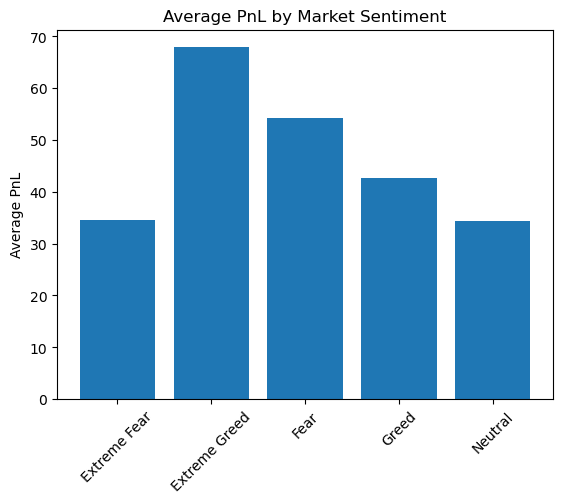

In [17]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(pnl_sentiment['classification'], pnl_sentiment['closed_pnl'])
plt.xticks(rotation=45)
plt.ylabel("Average PnL")
plt.title("Average PnL by Market Sentiment")
plt.show()


In [18]:
merged['win'] = merged['closed_pnl'] > 0
winrate_sentiment = merged.groupby('classification')['win'].mean()*100
print(winrate_sentiment)


classification
Extreme Fear     37.060748
Extreme Greed    46.494299
Fear             42.076750
Greed            38.482794
Neutral          39.699093
Name: win, dtype: float64


In [19]:
loss = merged[merged['closed_pnl'] < 0]
drawdown = loss.groupby('classification')['closed_pnl'].mean()
print(drawdown)


classification
Extreme Fear    -257.099629
Extreme Greed   -119.920289
Fear            -156.662401
Greed           -181.967329
Neutral         -121.727849
Name: closed_pnl, dtype: float64


In [20]:
## Question 2
freq = merged.groupby(['date','classification']).size().reset_index(name='trades')
print(freq.groupby('classification')['trades'].mean())


classification
Extreme Fear     1528.571429
Extreme Greed     350.807018
Fear              679.527473
Greed             260.637306
Neutral           562.477612
Name: trades, dtype: float64


In [21]:
print(merged.groupby('classification')['size_usd'].mean())


classification
Extreme Fear     5349.731843
Extreme Greed    3112.251565
Fear             7816.109931
Greed            5736.884375
Neutral          4782.732661
Name: size_usd, dtype: float64


In [22]:
bias = pd.crosstab(merged['classification'], merged['side'], normalize='index')*100
print(bias)


side                  BUY       SELL
classification                      
Extreme Fear    51.098131  48.901869
Extreme Greed   44.858972  55.141028
Fear            48.951275  51.048725
Greed           48.855933  51.144067
Neutral         50.334342  49.665658


In [23]:
merged['leverage'] = merged['size_usd'] / merged['size_usd'].median()
print(merged.groupby('classification')['leverage'].mean())


classification
Extreme Fear      8.960349
Extreme Greed     5.212759
Fear             13.091325
Greed             9.608797
Neutral           8.010674
Name: leverage, dtype: float64


In [24]:
lev = merged.groupby('account')['leverage'].mean()
high_lev = lev[lev > lev.median()]
low_lev = lev[lev <= lev.median()]


In [25]:
freq = merged.groupby('account').size()
frequent = freq[freq > freq.median()]
infrequent = freq[freq <= freq.median()]


In [26]:
winrate = merged.groupby('account')['win'].mean()
consistent = winrate[winrate > 0.6]


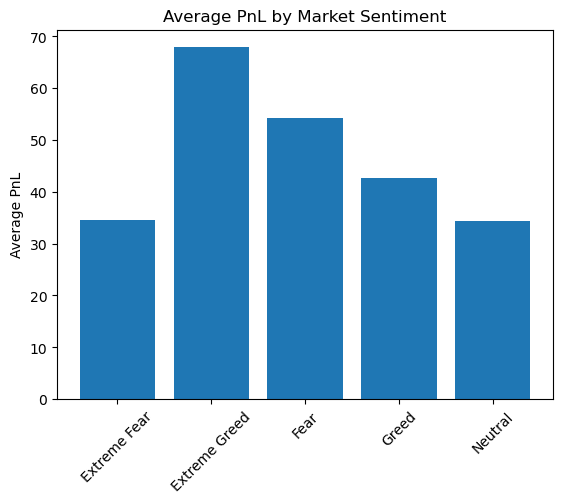

In [27]:
import matplotlib.pyplot as plt
plt.figure()
plt.bar(pnl_sentiment['classification'], pnl_sentiment['closed_pnl'])
plt.xticks(rotation=45)
plt.ylabel("Average PnL")
plt.title("Average PnL by Market Sentiment")

plt.savefig("outputs/pnl_vs_sentiment.png", bbox_inches='tight')
plt.show()


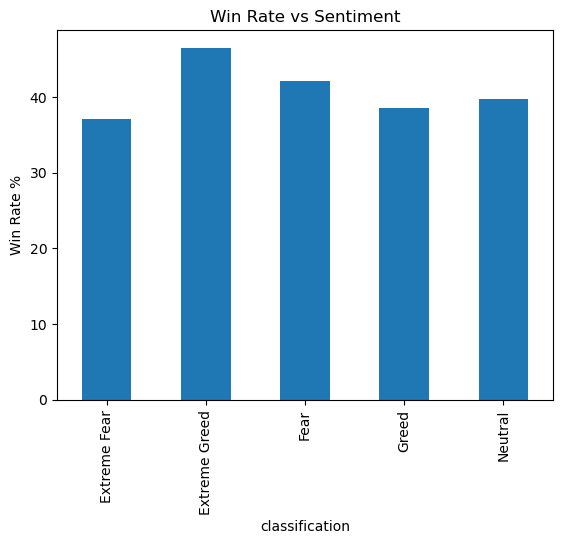

In [28]:
plt.figure()
winrate_sentiment.plot(kind='bar')
plt.title("Win Rate vs Sentiment")
plt.ylabel("Win Rate %")

plt.savefig("outputs/winrate_vs_sentiment.png", bbox_inches='tight')
plt.show()



# Part D — Predictive Modeling (Optional Extension)
Predict next-day trader profitability using sentiment and behavioral features.


In [29]:
# make sure data is ordered correctly
merged = merged.sort_values(['account','date'])

# next day pnl for each trader
merged['next_day_pnl'] = merged.groupby('account')['closed_pnl'].shift(-1)

# classification target: 1 = profit tomorrow, 0 = loss tomorrow
merged['profit_tomorrow'] = (merged['next_day_pnl'] > 0).astype(int)

merged[['account','date','closed_pnl','next_day_pnl','profit_tomorrow']].head(10)


,account,date,closed_pnl,next_day_pnl,profit_tomorrow
14229,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,0.0,0
14230,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,0.0,0
14231,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,0.0,0
14232,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,0.0,0
14233,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,0.0,0
14234,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,0.0,0
14235,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,0.0,0
14236,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,0.0,0
14237,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,0.0,0
14238,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,0.0,0


In [30]:
# create daily trader summary
daily_trader = merged.groupby(['account','date']).agg({
    'closed_pnl':'sum',
    'size_usd':'mean',
    'leverage':'mean',
    'win':'mean',
    'value':'mean'
}).reset_index()

daily_trader.head()


,account,date,closed_pnl,size_usd,leverage,win,value
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,5089.718249,8.524849,0.000000,76.0
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,7976.664412,13.360240,0.000000,90.0
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,23734.500000,39.753285,0.000000,83.0
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,28186.666667,47.210288,0.000000,94.0
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1,17248.148148,28.889193,0.444444,79.0


In [31]:
# sort properly
daily_trader = daily_trader.sort_values(['account','date'])

# next day pnl
daily_trader['next_day_pnl'] = daily_trader.groupby('account')['closed_pnl'].shift(-1)

# classification target
daily_trader['profit_tomorrow'] = (daily_trader['next_day_pnl'] > 0).astype(int)

daily_trader[['account','date','closed_pnl','next_day_pnl','profit_tomorrow']].head(10)


,account,date,closed_pnl,next_day_pnl,profit_tomorrow
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.000000,0.000000,0
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.000000,0.000000,0
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.000000,-21227.000000,0
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.000000,1603.100000,1
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.100000,-132271.000000,0
5,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-28,-132271.000000,0.000000,0
6,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-30,0.000000,-175611.000056,0
7,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-12-06,-175611.000056,71393.964098,1
8,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-01-19,71393.964098,40218.599998,1
9,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-01-20,40218.599998,76710.000000,1


In [32]:
daily_trader = daily_trader.dropna(subset=['next_day_pnl'])

print(daily_trader.shape)


(2309, 9)


In [33]:
# Features we will use
X = daily_trader[['closed_pnl','size_usd','leverage','win','value']]

# Target
y = daily_trader['profit_tomorrow']

print(X.head())
print(y.head())


   closed_pnl      size_usd   leverage       win  value
0         0.0   5089.718249   8.524849  0.000000   76.0
1         0.0   7976.664412  13.360240  0.000000   90.0
2         0.0  23734.500000  39.753285  0.000000   83.0
3    -21227.0  28186.666667  47.210288  0.000000   94.0
4      1603.1  17248.148148  28.889193  0.444444   79.0
0    0
1    0
2    0
3    1
4    0
Name: profit_tomorrow, dtype: int64


In [35]:
# remove rows with missing features
data_model = daily_trader[['closed_pnl','size_usd','leverage','win','value','profit_tomorrow']].dropna()

X = data_model[['closed_pnl','size_usd','leverage','win','value']]
y = data_model['profit_tomorrow']

print("Rows after cleaning:", data_model.shape)


Rows after cleaning: (2308, 6)


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# create model
model = LogisticRegression(max_iter=1000)

# train
model.fit(X_train, y_train)

# predict
pred = model.predict(X_test)

# results
print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))


Accuracy: 0.6233766233766234
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       174
           1       0.62      1.00      0.77       288

    accuracy                           0.62       462
   macro avg       0.31      0.50      0.38       462
weighted avg       0.39      0.62      0.48       462



e:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
e:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
e:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [38]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))


Accuracy: 0.6082251082251082
              precision    recall  f1-score   support

           0       0.48      0.64      0.55       174
           1       0.73      0.59      0.65       288

    accuracy                           0.61       462
   macro avg       0.61      0.62      0.60       462
weighted avg       0.64      0.61      0.61       462



## Clustering traders into behavioral archetypes (optional)

In [39]:
# summarize each trader behaviour
trader_features = merged.groupby('account').agg({
    'closed_pnl':'mean',
    'leverage':'mean',
    'size_usd':'mean',
    'win':'mean',
    'date':'count'
}).rename(columns={'date':'trade_count'}).reset_index()

trader_features.head()


,account,closed_pnl,leverage,size_usd,win,trade_count
0,0x083384f897ee0f19899168e3b1bec365f52a9012,419.127768,27.065928,16159.576734,0.359612,3818
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,6.577654,2.769015,1653.226327,0.442720,7280
2,0x271b280974205ca63b716753467d5a371de622ab,-18.492043,14.895026,8893.000898,0.301917,3809
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,9.951530,0.850232,507.626933,0.438585,13311
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,52.071011,5.257384,3138.894782,0.519914,3239


In [40]:
from sklearn.preprocessing import StandardScaler

# remove account column before scaling
X_cluster = trader_features.drop('account', axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

print(X_scaled[:5])


[[ 2.42062214  1.4165638   1.4165638  -0.40687769 -0.3426847 ]
 [-0.68609565 -0.60765652 -0.60765652  0.37135943  0.08364696]
 [-0.87488356  0.40258371  0.40258371 -0.94715499 -0.34379301]
 [-0.66068861 -0.76751379 -0.76751379  0.33263692  0.82634085]
 [-0.34350692 -0.40034591 -0.40034591  1.09421982 -0.41398627]]


In [41]:
from sklearn.cluster import KMeans

# choose number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)

# fit model
trader_features['cluster'] = kmeans.fit_predict(X_scaled)

trader_features.head()


e:\Users\HP\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,account,closed_pnl,leverage,size_usd,win,trade_count,cluster
0,0x083384f897ee0f19899168e3b1bec365f52a9012,419.127768,27.065928,16159.576734,0.359612,3818,0
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,6.577654,2.769015,1653.226327,0.442720,7280,2
2,0x271b280974205ca63b716753467d5a371de622ab,-18.492043,14.895026,8893.000898,0.301917,3809,2
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,9.951530,0.850232,507.626933,0.438585,13311,1
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,52.071011,5.257384,3138.894782,0.519914,3239,2


In [43]:
cluster_summary = trader_features.groupby('cluster').mean(numeric_only=True)
print(cluster_summary)


         closed_pnl   leverage      size_usd       win   trade_count
cluster                                                             
0        133.300246  37.752131  22539.720976  0.389945   7119.000000
1         38.390661   3.208530   1915.636756  0.379881  20003.833333
2        107.382570   6.897686   4118.228881  0.411770   2851.136364


## A lightweight dashboard (Streamlit) to explore results (optional)

In [45]:
# save merged dataset
merged.to_csv("merged_data.csv", index=False)

# save cluster data
trader_features.to_csv("trader_clusters.csv", index=False)


In [46]:
# ---- PnL summary ----
pnl_summary = merged.groupby('classification')['closed_pnl'].mean().reset_index()
pnl_summary.to_csv("pnl_summary.csv", index=False)

# ---- Winrate summary ----
merged['win'] = merged['closed_pnl'] > 0
win_summary = merged.groupby('classification')['win'].mean().reset_index()
win_summary.to_csv("win_summary.csv", index=False)

# ---- clusters ----
trader_features.to_csv("trader_clusters.csv", index=False)
